# OMPL Projection based sampling convergence for different robots

The projection method used in the experiments (from the OMPL source code) is:

```C++
bool ompl::base::Constraint::project(Eigen::Ref<Eigen::VectorXd> x) const
{
    // Newton's method
    unsigned int iter = 0;
    double norm = 0;
    Eigen::VectorXd f(getCoDimension());
    Eigen::MatrixXd j(getCoDimension(), n_);

    const double squaredTolerance = tolerance_ * tolerance_;

    function(x, f);
    while ((norm = f.squaredNorm()) > squaredTolerance && iter++ < maxIterations_)
    {
        jacobian(x, j);
        x -= j.jacobiSvd(Eigen::ComputeThinU | Eigen::ComputeThinV).solve(f);
        function(x, f);
    }

    return norm < squaredTolerance;
}
```

I used an `ompl::base::RealVectorStateSpace` for the uniform sampling, that has the bounds set to the robot's joint limits. This I project this state with the above method, for different settings of `maxIterations_`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from plot_functions import *

## Kuka KR5

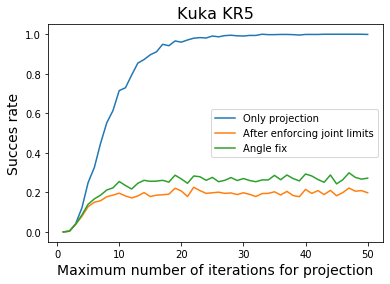

In [3]:
# fig1, ax1 = plot_iter_vs_success_rate("data/kuka_kr5_projection.txt", "Kuka KR5")
# fig1, ax1 = plot_iter_vs_success_rate("data/kuka_kr5_use_joint_limits.txt", "Kuka KR5")
fig1, ax1 = plot_iter_vs_success_rate("data/kuka_kr5_1000_runs.txt", "Kuka KR5")
# plt.savefig("figures/kuka_kr5_results.png")

The error data contains a long list of pairs (index, error) for 10 runs in total. Below, we reorganize the data in a square matrix 10 x `max_iters`. For cases where convergence took less than `max_iters`, we leave it zero.

In [17]:
# dd = read_and_transform_error_data("data/kuka_kr5_error.txt")
# fig, ax = plot_error_data(dd, "Kuka KR5")
# plt.savefig("figures/kuka_kr5_error.png")

## Fanuc

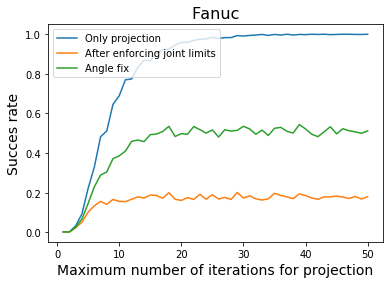

In [5]:
# fig1, ax1 = plot_iter_vs_success_rate("data/fanuc_projection.txt", "Fanuc")
fig1, ax1 = plot_iter_vs_success_rate("data/fanuc_use_joint_limits.txt", "Fanuc")
# plt.savefig("figures/fanuc_success_rate.png")

## Panda

I changed the nominal position of the box for the position constraints, to put it in the Panda's workspace
```C++
geometry_msgs::Pose box_pose;
box_pose.position.x = 0.3;
box_pose.position.y = 0.0;
box_pose.position.z = 0.5;
box_pose.orientation.w = 1.0;
```

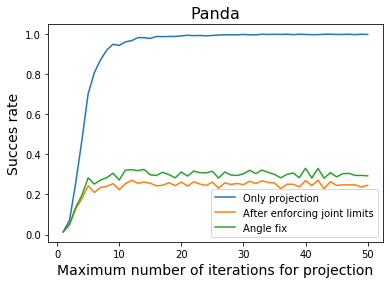

In [16]:
# fig1, ax1 = plot_iter_vs_success_rate("data/panda_projection.txt", "Panda")
# fig1, ax1 = plot_iter_vs_success_rate("data/panda_use_joint_limits.txt", "Panda")
fig1, ax1 = plot_iter_vs_success_rate("data/panda_1000_runs.txt", "Panda")

In [7]:
# old data with wrong box pose
# dd = read_and_transform_error_data("data/panda_error.txt")
# fig, ax = plot_error_data(dd, "Panda")

In [8]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(dd, ".--")
# ax.set_title("Panda", fontsize=14)
# ax.set_xlabel("Number of iterations for projection")
# ax.set_ylabel("Squared norm of constraint deviation")
# ax.set_xlim([0, 50])
# plt.savefig("figures/panda_error.png")

## Create combined plot for all the robots

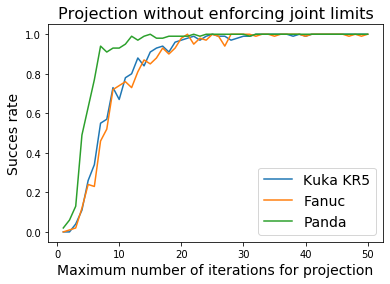

In [9]:
robots = ["Kuka KR5", "Fanuc", "Panda"]
filepaths = ["kuka_kr5_projection.txt", "fanuc_projection.txt", "panda_projection.txt"]
data = [np.loadtxt("data/" + path, delimiter=",") for path in filepaths]

fig, ax = plt.subplots()
for d in data:
    ax.plot(d[:, 0], d[:, 1] / d[:, 2])
ax.set_title("Projection without enforcing joint limits", fontsize=16)
ax.set_xlabel("Maximum number of iterations for projection", fontsize=14)
ax.set_ylabel("Succes rate", fontsize=14)
ax.legend(robots, fontsize=14)
plt.savefig("figures/sr_vs_max_iters.png", )

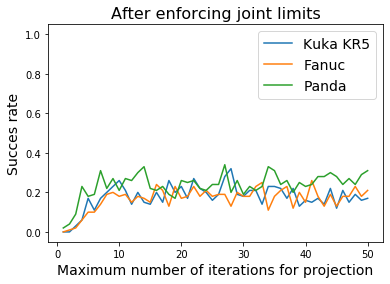

In [10]:
robots = ["Kuka KR5", "Fanuc", "Panda"]
filepaths = ["kuka_kr5_projection.txt", "fanuc_projection.txt", "panda_projection.txt"]
data = [np.loadtxt("data/" + path, delimiter=",") for path in filepaths]

fig, ax = plt.subplots()
for d in data:
    ax.plot(d[:, 0], d[:, 3] / d[:, 2])
ax.set_title("After enforcing joint limits", fontsize=16)
ax.set_xlabel("Maximum number of iterations for projection", fontsize=14)
ax.set_ylabel("Succes rate", fontsize=14)
ax.set_ylim((-0.05, 1.05))
ax.legend(robots, fontsize=14)
plt.savefig("figures/sr_vs_max_iters_after.png", )

# Harmonize joints towards joint limits

After projection it is not guaranteed the the solution will lie inside the joint limits. The current approach in the uniform sampler it to clip the joints to its limits. As smarter approach is to check we can get the joint within its limits by adding or subtracking mulitples of $2 \pi$. The code I used to do this is shown below. It only tries $\pm 2 \pi$ and not multiples because there are rarly needed for the three cases analysed in this notebook.

```C++
/** Try to move joints inside its limits.

\param q: pointer to the array with joint values.
\param rvss: The state space that contains the joint limit info.
**/
void applyJointLimits(double* q, ompl::base::RealVectorStateSpacePtr& rvss)
{
  const static double two_pi = 2.0 * M_PI;
  auto bounds = rvss->getBounds();
  for (unsigned int i{ 0 }; i < rvss->getDimension(); ++i)
  {
    if (q[i] > bounds.high.at(i))
    {
      if ((q[i] - two_pi) >= bounds.low.at(i))
        q[i] -= two_pi;
    }
    else if (q[i] < bounds.low.at(i))
    {
      if ((q[i] + two_pi) <= bounds.high.at(i))
        q[i] += two_pi;
    }
  }
}
```